In [185]:
import pandas as pd
from datetime import datetime, date, timedelta
import os
import glob
from difflib import get_close_matches
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from scipy.sparse import csr_matrix
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import sparse_dot_topn.sparse_dot_topn as ct
import matplotlib.pyplot as plt

In [134]:
stock_industries_file = os.path.join("output\sp500\industries", "sp500_industries.csv")
df_industries = pd.read_csv(stock_industries_file)
#df_industries.head(20)
sp500_names=df_industries.loc[:,["ticker", "longName"]]

In [135]:
unofficial_name=[]

for name in sp500_names["longName"]:
    x=name.rstrip("Inc.").rstrip("plc").rstrip("Incorporated").rstrip("Corporatio").strip().rstrip(",")
    unofficial_name.append(x)

sp500_names["unofficial_name"]= unofficial_name

In [136]:
sp500_names.head(20)

,ticker,longName,unofficial_name
0,A,"Agilent Technologies, Inc.",Agilent Technologies
1,AAL,American Airlines Group Inc.,American Airlines Group
2,AAP,"Advance Auto Parts, Inc.",Advance Auto Parts
3,AAPL,Apple Inc.,Apple
4,ABBV,AbbVie Inc.,AbbVie
5,ABC,AmerisourceBergen Corporation,AmerisourceBergen
6,ABMD,"Abiomed, Inc.",Abiomed
7,ABT,Abbott Laboratories,Abbott Laboratories
8,ACN,Accenture plc,Accenture
9,ADBE,Adobe Inc.,Adobe


In [137]:
sdate = date(2020, 3, 1)   # start date
edate = date(2020, 10, 1)   # end date

delta = edate - sdate       # as timedelta


date_list= []
for i in range(delta.days + 1):
    day = sdate + timedelta(days=i)
    date_list.append(day)
    #print(day)

#print(date_list)

len(date_list)

215

In [138]:
all_files = []
for date in date_list:
    path = f"results\{date}"
    all_files.append(glob.glob(path + "\*.txt"))

print(all_files)

[['results\\2020-03-01\\Asian stock markets reverse losses on global policy stimulus hopes.txt', 'results\\2020-03-01\\Energy & Precious Metals - Weekly Review and Calendar Ahead.txt', 'results\\2020-03-01\\U.S. officials talk down coronavirus market panic, tout economic strength.txt'], ['results\\2020-03-02\\Coronavirus expected to hurt U.S. earnings harder and longer.txt', 'results\\2020-03-02\\Oil Ends up Nearly 5% on OPEC, Global Rate Cut Hopes.txt', 'results\\2020-03-02\\Stocks - S&P Soars on Bets of Central Banks Stimulus, Slowing China Infections.txt', 'results\\2020-03-02\\Stocks - Wall Street Retreats From Highs After Increase in  U.S. Virus Death Toll.txt', 'results\\2020-03-02\\Stocks - Wall Street Surges at the Close as Financials, Tech Jump.txt', 'results\\2020-03-02\\Stocks – Wall Street Rallies, but Trading Remains Volatile.txt', 'results\\2020-03-02\\U.S. stock short-sellers notch $105 billion week in coronavirus sell-off.txt', 'results\\2020-03-02\\U.S. stocks higher a

In [139]:
text=[]

for file_block in all_files:
    for filename in file_block:
        df = open(filename)
        rows = [str(row) for row in df]
        df.close()
        text.append(rows)
        
print(text)

[['By Tom Westbrook and Swati Pandey SINGAPORE (Reuters) - Asian shares steadied from early losses on Monday as investors placed their hopes on a coordinated global monetary policy response to weather the damaging economic impact of the coronavirus epidemic. Pandemic fears pushed markets off a precipice last week, wiping more than $5 trillion from global share value as stocks cratered to their steepest slump in more than a decade. The sheer scale of losses prompted financial markets to price in policy responses from the U.S. Federal Reserve to the Bank of Japan and the Reserve Bank of Australia. Futures now imply a full 50 basis point cut by the Fed in March  while Australian markets are pricing in a quarter-point cut at the RBA\'s Tuesday meeting. Also helping calm market nerves, Bank of Japan Governor Haruhiko Kuroda said on Monday the central bank would take necessary steps to stabilise financial markets. [ In equities, Chinese shares opened higher with the blue-chip index ( ) up 1.

In [140]:
names=[]

for file_block in all_files:
    for filename in file_block:
        name=filename.split("\\")[2].rstrip(".txt")
        names.append(name)

In [141]:
dates=[]

for file_block in all_files:
    for filename in file_block:
        date=filename.split("\\")[1]
        dates.append(date)
        
print(dates)

['2020-03-01', '2020-03-01', '2020-03-01', '2020-03-02', '2020-03-02', '2020-03-02', '2020-03-02', '2020-03-02', '2020-03-02', '2020-03-02', '2020-03-02', '2020-03-03', '2020-03-03', '2020-03-03', '2020-03-03', '2020-03-03', '2020-03-03', '2020-03-03', '2020-03-03', '2020-03-04', '2020-03-04', '2020-03-04', '2020-03-04', '2020-03-04', '2020-03-05', '2020-03-05', '2020-03-05', '2020-03-05', '2020-03-05', '2020-03-05', '2020-03-06', '2020-03-06', '2020-03-06', '2020-03-06', '2020-03-06', '2020-03-06', '2020-03-06', '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09', '2020-03-09', '2020-03-09', '2020-03-09', '2020-03-09', '2020-03-09', '2020-03-09', '2020-03-09', '2020-03-09', '2020-03-09', '2020-03-09', '2020-03-10', '2020-03-10', '2020-03-10', '2020-03-10', '2020-03-10', '2020-03-10', '2020-03-11', '2020-03-11', '2020-03-11', '2020-03-11', '2020-03-11', '2020-03-11', '2020-03-11', '2020-03-11', '2020-03-11', '2020-03-11', '2020-03-11', '2020-03-11', '2020-03-12', '2020-03-12', '2020

In [142]:
dict=[]
for n, d, t in zip(names, dates, text):
    dict_x={"name":n, "date":d, "text":t}
    dict.append(dict_x)

print(dict)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [143]:
df_news=pd.DataFrame(dict, columns=["name", "date", "text"])

In [144]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1192 entries, 0 to 1191
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    1192 non-null   object
 1   date    1192 non-null   object
 2   text    1192 non-null   object
dtypes: object(3)
memory usage: 28.1+ KB


In [145]:
df_news.head(20)

,name,date,text
0,Asian stock markets reverse losses on global p...,2020-03-01,[By Tom Westbrook and Swati Pandey SINGAPORE (...
1,Energy & Precious Metals - Weekly Review and C...,2020-03-01,[By Barani Krishnan Investing.com - How much ...
2,U.S. officials talk down coronavirus market pa...,2020-03-01,[By Michelle Price WASHINGTON (Reuters) - Seni...
3,Coronavirus expected to hurt U.S. earnings har...,2020-03-02,[By Caroline Valetkevitch NEW YORK (Reuters) -...
4,"Oil Ends up Nearly 5% on OPEC, Global Rate Cut...",2020-03-02,[By Barani Krishnan Investing.com - Oil price...
5,Stocks - S&P Soars on Bets of Central Banks St...,2020-03-02,[By Yasin Ebrahim By Yasin Ebrahim Investing...
6,Stocks - Wall Street Retreats From Highs After...,2020-03-02,[By Yasin Ebrahim Investing.com – The eased...
7,Stocks - Wall Street Surges at the Close as Fi...,2020-03-02,[By Yasin Ebrahim Investing.com – Stocks made...
8,"Stocks – Wall Street Rallies, but Trading Rema...",2020-03-02,[By Kim Khan Investing.com - The major stock ...
9,U.S. stock short-sellers notch $105 billion we...,2020-03-02,[By Saqib Iqbal Ahmed and Kate Duguid NEW YORK...


In [146]:
df_news["text"]=[str(text)[1:-1] for text in df_news["text"]]

In [147]:
df_news.head(20)

,name,date,text
0,Asian stock markets reverse losses on global p...,2020-03-01,'By Tom Westbrook and Swati Pandey SINGAPORE (...
1,Energy & Precious Metals - Weekly Review and C...,2020-03-01,"""By Barani Krishnan Investing.com - How much ..."
2,U.S. officials talk down coronavirus market pa...,2020-03-01,'By Michelle Price WASHINGTON (Reuters) - Seni...
3,Coronavirus expected to hurt U.S. earnings har...,2020-03-02,'By Caroline Valetkevitch NEW YORK (Reuters) -...
4,"Oil Ends up Nearly 5% on OPEC, Global Rate Cut...",2020-03-02,'By Barani Krishnan Investing.com - Oil price...
5,Stocks - S&P Soars on Bets of Central Banks St...,2020-03-02,"""By Yasin Ebrahim By Yasin Ebrahim Investing..."
6,Stocks - Wall Street Retreats From Highs After...,2020-03-02,"""By Yasin Ebrahim Investing.com – The eased..."
7,Stocks - Wall Street Surges at the Close as Fi...,2020-03-02,"""By Yasin Ebrahim Investing.com – Stocks made..."
8,"Stocks – Wall Street Rallies, but Trading Rema...",2020-03-02,'By Kim Khan Investing.com - The major stock ...
9,U.S. stock short-sellers notch $105 billion we...,2020-03-02,'By Saqib Iqbal Ahmed and Kate Duguid NEW YORK...


In [148]:
# Sentiment Analysis
analyzer = SentimentIntensityAnalyzer()

scores = df_news["text"].apply(analyzer.polarity_scores).tolist()

df_scores = pd.DataFrame(scores)
df_news = df_news.join(df_scores, rsuffix='_right')

In [149]:
def ngrams(string, n=3):
    string = re.sub(r'[,-./]|\sBD',r'', string)
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams]

ngrams("Apple is green and the tree is red")

['App',
 'ppl',
 'ple',
 'le ',
 'e i',
 ' is',
 'is ',
 's g',
 ' gr',
 'gre',
 'ree',
 'een',
 'en ',
 'n a',
 ' an',
 'and',
 'nd ',
 'd t',
 ' th',
 'the',
 'he ',
 'e t',
 ' tr',
 'tre',
 'ree',
 'ee ',
 'e i',
 ' is',
 'is ',
 's r',
 ' re',
 'red']

In [150]:
company_names = sp500_names["unofficial_name"].str.lower()
article_headlines=df_news["name"].str.lower()
vectorizer = TfidfVectorizer(min_df=1, analyzer='char_wb', ngram_range=(3,3))
tf_idf_matrix = vectorizer.fit_transform(article_headlines)
query_vec=vectorizer.transform(company_names)

In [151]:
results = cosine_similarity(tf_idf_matrix,query_vec)
print(results)

[[0.0090933  0.03357652 0.01080787 ... 0.0100623  0.01361465 0.        ]
 [0.0444291  0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.02202654 ... 0.         0.02766988 0.        ]
 ...
 [0.         0.         0.03328065 ... 0.         0.         0.        ]
 [0.0056512  0.03847777 0.         ... 0.0062534  0.01052897 0.        ]
 [0.         0.0164978  0.01291874 ... 0.         0.01034315 0.        ]]


In [152]:
df_names=pd.DataFrame(data=results)

In [153]:
df_names.head(20)

,0,1,2,3,4,5,6,7,8,9,...,492,493,494,495,496,497,498,499,500,501
0,0.009093,0.033577,0.010808,0.000000,0.000000,0.000000,0.000000,0.007592,0.000000,0.0,...,0.000000,0.010557,0.000000,0.031110,0.0,0.000000,0.025275,0.010062,0.013615,0.0
1,0.044429,0.000000,0.000000,0.000000,0.064248,0.030561,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.021016,0.000000,0.0,0.026679,0.069660,0.000000,0.000000,0.0
2,0.000000,0.000000,0.022027,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.054143,0.000000,0.0,0.000000,0.009267,0.000000,0.027670,0.0
3,0.000000,0.000000,0.014310,0.000000,0.000000,0.000000,0.027764,0.000000,0.000000,0.0,...,0.000000,0.044028,0.062596,0.048799,0.0,0.029155,0.056209,0.000000,0.031990,0.0
4,0.004781,0.018770,0.000000,0.000000,0.000000,0.000000,0.000000,0.035499,0.000000,0.0,...,0.000000,0.043410,0.023787,0.032714,0.0,0.049521,0.026579,0.005291,0.035087,0.0
5,0.023593,0.000000,0.010261,0.000000,0.000000,0.000000,0.000000,0.000000,0.096662,0.0,...,0.000000,0.010023,0.069657,0.008516,0.0,0.000000,0.006918,0.000000,0.143973,0.0
6,0.000000,0.000000,0.010744,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.025904,0.000000,0.0,0.000000,0.018598,0.000000,0.000000,0.0
7,0.063366,0.004965,0.039645,0.000000,0.000000,0.035181,0.000000,0.004658,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.012947,0.070118,0.033780,0.0
8,0.087854,0.000000,0.000000,0.057337,0.000000,0.000000,0.000000,0.030017,0.000000,0.0,...,0.000000,0.000000,0.000000,0.071188,0.0,0.000000,0.069872,0.039782,0.056096,0.0
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.055631,0.051684,0.000000,0.0,0.000000,0.023710,0.000000,0.058290,0.0


In [154]:
df_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1192 entries, 0 to 1191
Columns: 502 entries, 0 to 501
dtypes: float64(502)
memory usage: 4.6 MB


In [155]:
df_names=df_names.rename(columns=sp500_names["ticker"], index=df_news["name"]).reset_index()

In [156]:
df_names=df_names.rename(columns={"index":"name"})

In [157]:
df_names.head(500)

,name,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,Asian stock markets reverse losses on global p...,0.009093,0.033577,0.010808,0.0,0.000000,0.000000,0.000000,0.007592,0.000000,...,0.0,0.010557,0.000000,0.031110,0.0,0.000000,0.025275,0.010062,0.013615,0.0
1,Energy & Precious Metals - Weekly Review and C...,0.044429,0.000000,0.000000,0.0,0.064248,0.030561,0.000000,0.000000,0.000000,...,0.0,0.000000,0.021016,0.000000,0.0,0.026679,0.069660,0.000000,0.000000,0.0
2,U.S. officials talk down coronavirus market pa...,0.000000,0.000000,0.022027,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.054143,0.000000,0.0,0.000000,0.009267,0.000000,0.027670,0.0
3,Coronavirus expected to hurt U.S. earnings har...,0.000000,0.000000,0.014310,0.0,0.000000,0.000000,0.027764,0.000000,0.000000,...,0.0,0.044028,0.062596,0.048799,0.0,0.029155,0.056209,0.000000,0.031990,0.0
4,"Oil Ends up Nearly 5% on OPEC, Global Rate Cut...",0.004781,0.018770,0.000000,0.0,0.000000,0.000000,0.000000,0.035499,0.000000,...,0.0,0.043410,0.023787,0.032714,0.0,0.049521,0.026579,0.005291,0.035087,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,Stocks - Dow Soars as Vaccine Hopes Trigger Se...,0.005306,0.065603,0.000000,0.0,0.000000,0.026407,0.000000,0.004431,0.058918,...,0.0,0.000000,0.000000,0.036308,0.0,0.000000,0.039017,0.005872,0.006003,0.0
496,Stocks - Wall Street Jumps at Opening on Reope...,0.005149,0.029438,0.000000,0.0,0.000000,0.000000,0.000000,0.004299,0.057172,...,0.0,0.011956,0.000000,0.073271,0.0,0.000000,0.071479,0.005698,0.000000,0.0
497,U.S. stocks higher at close of trade; Dow Jone...,0.005583,0.038011,0.000000,0.0,0.000000,0.000000,0.000000,0.004661,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.010015,0.006178,0.010401,0.0
498,"Home Depot Earnings Miss, Revenue Beats In Q1",0.000000,0.000000,0.014415,0.0,0.000000,0.000000,0.093946,0.000000,0.000000,...,0.0,0.000000,0.034754,0.105595,0.0,0.000000,0.138946,0.000000,0.000000,0.0


In [158]:
df_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1192 entries, 0 to 1191
Columns: 503 entries, name to ZTS
dtypes: float64(502), object(1)
memory usage: 4.6+ MB


In [159]:
df_names.tail(50)

,name,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
1142,Nike Jumps on Blowout Q1 Earnings Amid Direct ...,0.000000,0.057691,0.013599,0.000000,0.0,0.063628,0.000000,0.000000,0.000000,...,0.000000,0.010187,0.000000,0.046376,0.000000,0.000000,0.089528,0.000000,0.016905,0.0
1143,U.S. Futures Edge Higher Ahead of Powell Testi...,0.021808,0.004853,0.000000,0.000000,0.0,0.000000,0.000000,0.004552,0.064392,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009781,0.024132,0.000000,0.0
1144,U.S. stocks higher at close of trade; Dow Jone...,0.005700,0.038810,0.000000,0.000000,0.0,0.000000,0.000000,0.004759,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010226,0.006307,0.010620,0.0
1145,"Wall Street closes higher on Amazon boost, des...",0.041159,0.033777,0.000000,0.000000,0.0,0.028205,0.000000,0.074831,0.000000,...,0.000000,0.021399,0.026409,0.000000,0.000000,0.000000,0.018961,0.045545,0.000000,0.0
1146,Wall Street Opens Higher in Cautious Bounce; T...,0.013919,0.000000,0.077672,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.023084,0.000000,0.000000,0.000000,0.019092,0.015402,0.044884,0.0
1147,'Active' fund managers beaten by benchmarks du...,0.000000,0.000000,0.000000,0.000000,0.0,0.018166,0.000000,0.000000,0.000000,...,0.046067,0.000000,0.000000,0.007202,0.000000,0.000000,0.005851,0.000000,0.032539,0.0
1148,"Cintas Earnings, Revenue Beat in Q1",0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.039971,0.000000,0.000000,0.032474,0.000000,0.000000,0.0
1149,Dow Futures Rise 225 Pts; Nike Set to Shine,0.005419,0.030981,0.016798,0.000000,0.0,0.029078,0.000000,0.004525,0.064001,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012577,0.005996,0.000000,0.0
1150,Dow Sheds 525 Points as Tech Rout Rattles Bulls,0.057643,0.047741,0.012062,0.000000,0.0,0.000000,0.000000,0.037677,0.000000,...,0.000000,0.000000,0.041894,0.000000,0.000000,0.024314,0.000000,0.063785,0.033526,0.0
1151,Dow Slumps as Tech Turns Ugly,0.073059,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.039141,...,0.000000,0.000000,0.035087,0.000000,0.000000,0.000000,0.000000,0.080845,0.021400,0.0


In [160]:
df_names.to_csv("Headlines_Companies_Matrix.csv", index="True")

In [161]:
index_names=["S&P"]

In [162]:
index = index_names
article_headlines=df_news["name"]
vectorizer = TfidfVectorizer(min_df=1, analyzer='char_wb', ngram_range=(3,3))
tf_idf_matrix = vectorizer.fit_transform(article_headlines)
query_vec=vectorizer.transform(index)

In [163]:
print(tf_idf_matrix)

  (0, 2616)	0.13455746372475108
  (0, 2518)	0.09463543960909399
  (0, 1763)	0.12897508754671402
  (0, 196)	0.12004015581340999
  (0, 3259)	0.0949985043060027
  (0, 2136)	0.12897508754671402
  (0, 3207)	0.12949253163845442
  (0, 2235)	0.12949253163845442
  (0, 1863)	0.13001825518614232
  (0, 3092)	0.11497522372711334
  (0, 2992)	0.12004015581340999
  (0, 1213)	0.21274226043849132
  (0, 1811)	0.22007409273509898
  (0, 2062)	0.19729934143800276
  (0, 2468)	0.18397696596595095
  (0, 2644)	0.2067517172630472
  (0, 263)	0.12123508825269924
  (0, 903)	0.09040634326479069
  (0, 1039)	0.1789120338796543
  (0, 2415)	0.1813470010587312
  (0, 2101)	0.1789120338796543
  (0, 1674)	0.17253264568369261
  (0, 188)	0.1706545904938991
  (0, 2484)	0.07887809695796529
  (0, 247)	0.0870876786881288
  :	:
  (1191, 248)	0.13472115888490013
  (1191, 3231)	0.12177454576684234
  (1191, 311)	0.12045205518815266
  (1191, 1465)	0.08151031743409465
  (1191, 3120)	0.09592028328261515
  (1191, 2995)	0.0788972892078961

In [164]:
results_1 = cosine_similarity(tf_idf_matrix,query_vec)
print(results)

[[0.0090933  0.03357652 0.01080787 ... 0.0100623  0.01361465 0.        ]
 [0.0444291  0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.02202654 ... 0.         0.02766988 0.        ]
 ...
 [0.         0.         0.03328065 ... 0.         0.         0.        ]
 [0.0056512  0.03847777 0.         ... 0.0062534  0.01052897 0.        ]
 [0.         0.0164978  0.01291874 ... 0.         0.01034315 0.        ]]


In [165]:
df_sp500_match=pd.DataFrame(data=results_1)

In [166]:
df_sp500_match.head(20)

,0
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.206042
6,0.000000
7,0.000000
8,0.000000
9,0.000000


In [167]:
df_sp500_match=df_sp500_match.rename(index=df_news["name"]).reset_index()

In [168]:
df_sp500_match.to_csv("Headlines_Index_Matrix.csv", index="True")

In [169]:
df_sp500_match.head(20)

,index,0
0,Asian stock markets reverse losses on global p...,0.000000
1,Energy & Precious Metals - Weekly Review and C...,0.000000
2,U.S. officials talk down coronavirus market pa...,0.000000
3,Coronavirus expected to hurt U.S. earnings har...,0.000000
4,"Oil Ends up Nearly 5% on OPEC, Global Rate Cut...",0.000000
5,Stocks - S&P Soars on Bets of Central Banks St...,0.206042
6,Stocks - Wall Street Retreats From Highs After...,0.000000
7,Stocks - Wall Street Surges at the Close as Fi...,0.000000
8,"Stocks – Wall Street Rallies, but Trading Rema...",0.000000
9,U.S. stock short-sellers notch $105 billion we...,0.000000


In [170]:
df_sp500_match.columns=["name", "sp500"]

In [171]:
df_sp500_match.head(20)

,name,sp500
0,Asian stock markets reverse losses on global p...,0.000000
1,Energy & Precious Metals - Weekly Review and C...,0.000000
2,U.S. officials talk down coronavirus market pa...,0.000000
3,Coronavirus expected to hurt U.S. earnings har...,0.000000
4,"Oil Ends up Nearly 5% on OPEC, Global Rate Cut...",0.000000
5,Stocks - S&P Soars on Bets of Central Banks St...,0.206042
6,Stocks - Wall Street Retreats From Highs After...,0.000000
7,Stocks - Wall Street Surges at the Close as Fi...,0.000000
8,"Stocks – Wall Street Rallies, but Trading Rema...",0.000000
9,U.S. stock short-sellers notch $105 billion we...,0.000000


In [172]:
df_news_1=df_news.merge(df_sp500_match, how="left",on="name")

In [176]:
df_news_1=df_news_1.merge(df_names, how="left", on="name")

In [177]:
df_news_1.to_csv("Headlines_all_matrix.csv",index="True")

In [179]:
df_news_sp500=df_news_1.loc[df_news_1["sp500"]>0.1]

In [180]:
mean_scores_sp500=df_news_sp500.groupby("date").mean()

In [182]:
mean_scores_sp500= mean_scores_sp500.xs('compound', axis="columns").transpose()

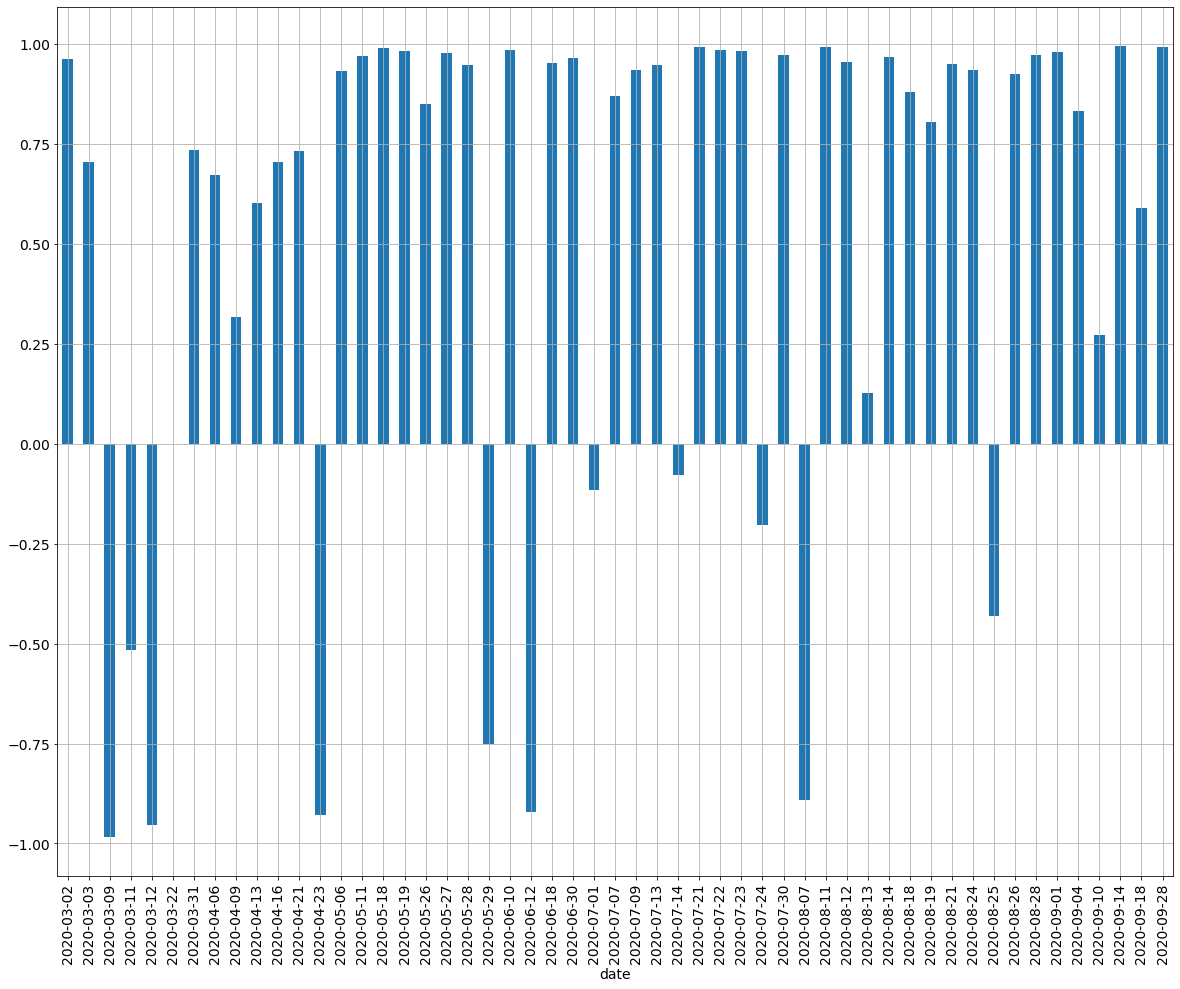

In [196]:
plt.rcParams['figure.figsize'] = [20, 16]
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

mean_scores_sp500.plot(kind = 'bar')
plt.grid()

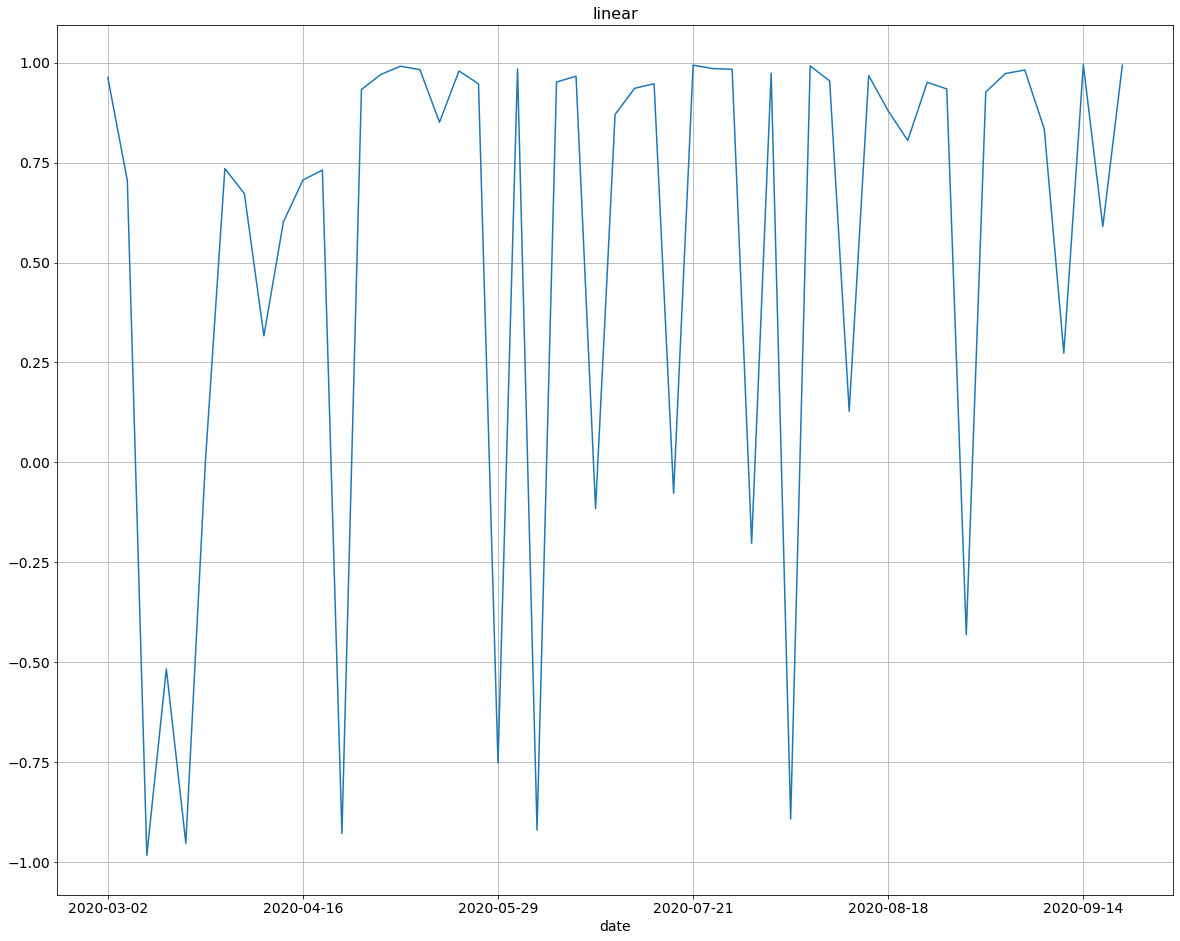

In [201]:
mean_scores_sp500.plot(kind = 'line')
plt.yscale('linear')
plt.title('linear')
plt.grid()